[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/051_gans/gans.ipynb)

# Laboratoro 5. Entrenamiento de una red GAN

## GENERADOR

CÓMO SABE EL GENERADOR QUE IMAGEN VA A GENERAR:\
-LE VAMOS A DAR A LA ENTRADA UN VECTOR CON RUIDO\
-DE ÉSTE VECTOR PODEMOS CONTROLAR LAS DIMENSIONES QUE TIENE. ESTE VECTOR PODEMOS VERLO COMO UNA CODIFICACIÓN DE LA IMAGEN QUE LUEGO EL GENERADOR VA A GENERAR JUGANDO CON TODOS ESTOS VALORES A LA ENTRADA -> ES UN VECTOR ALEATORIO, PODEMOS PONERLE LOS NÚMEROS QUE QUEREMOS.\
-CONTROLANDO ÉSTOS VALORES PODEMOS CONTROLAR DE FORMA MUY DETALLADA QUÉ ES LO QUE GENERA EL GENERADOR.\
-EJEMPLO DE LAS CARAS: PODEMOS PENSAR QUE UNO DE ESTOS VALORES PUEDE SER EL COLOR DEL PELO, EL COLOR DE LOS OJOS, PODEMOS AJUSTAR PARA GENERAR EXACTAMENTE LO QUE QUEREMOS.


## DISCRIMINADOR

EL DISCRIMINADOR RECIBE A LA ENTRADA IMÁGENES REALES DEL DATASET. AGARRA IMÁGENES REALES DEL DATASET Y TAMBIÉN IMÁGENES DEL GENERADOR.\
-SU TAREA ES DECIR: "ÉSTA IMAGEN ES REAL, VIENE DEL DATASET", O "ÉSTA IMAGEN ES FALSA, HA SIDO GENERADA POR EL GENERADOR"
-DE ESTA FORMA PODEMOS HACER UNA FUNCIÓN DE PÉRDIDA DE CLASIFICACIÓN BINARIA.

## OBJETIVO
-ENTRENAR ÉSTAS DOS REDES NEURONALES A LA VEZ EN ÉSTE SETUP QUE VA A SER COMPETITIVO, ADVERSARIO.
-EL GENERADOR INTENTA ENGAÑAR AL DISCRIMINADOR TODO EL TIEMPO Y EL DISCRIMINADOR VA A SER CADA VEZ MEJOR DETECTANDO LAS IMÁGENES FALSAS DEL GENERADOR.

-SI TODO VA BIEN, AL FINAL TENDREMOS: UN GENERADOR MUY BUENO Y UN DISCRIMINADOR QUE NO SABRÁ DISTINGUIR ENTRE IMÁGENES REALES O FALSAS.\
-REALMENTE ENTRENAR GANS ES COMPLICADO. ES COMPLICADO HACER CONVERGER ÉSTAS REDES NEURONALES A LA VEZ.

## ENTRENAMIENTO EN DOS FASES
1) PRIMERA FASE DISCRIMINADOR. En cada iteración, le damos un BATCH compuesto de imágenes reales del dataset e imágenes falsas generadas por el generador.\
-SE DEFINE UN CONJUNTO DE ETIQUETAS:\
0 -> Imágenes falsas y 1 -> Imágenes reales\
2) SEGUNDA FASE GENERADOR. En cada iteración, le daremos un BATCH compuesto de ruido aleatorio para que genere imágenes. Estas imágenes son introducidas en el discriminador, cuyas salidas (etiquetas real/falso) con comparadas con un conjunto de etiquetas definidas como reales.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##1. Configurar las transformaciones y cargar el dataset

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import numpy as np

# Ruta al dataset en Google Drive
data_dir = '/content/drive/MyDrive/SIS 421/LAB2/dataset_plantas'

# Transformaciones: Redimensionar si es necesario. Convertir a tensor
transform = transforms.Compose([
    transforms.Resize((50, 50)),
    transforms.ToTensor()
])

# Cargar el dataset con las transformaciones
full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Dividir en conjunto de entrenamiento (80%) y conjunto de prueba (20%)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size
trainset, testset = random_split(full_dataset, [train_size, test_size])

# Crear DataLoaders
trainloader = DataLoader(trainset, batch_size=16, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=16, shuffle=False, num_workers=2)

# Imprimir dimensiones
print(f"Total de imágenes en el dataset: {full_dataset}")
print(f"Tamaño del conjunto de entrenamiento: {train_size}")
print(f"Tamaño del conjunto de prueba: {test_size}")

# Verificar los TAMAÑOS DEL PRIMER BATCH en los DataLoaders. batch_size=16
for images, labels in trainloader:
    print("PRIMER BATCH TRAINLOADER")
    print(f"Tamaño de imágenes: {images.size()}")
    print(f"Tamaño de etiquetas: {labels.size()}")

    # Imprimir el valor mínimo y máximo de los tensores de imagen
    print(f"Valor mínimo de los tensores de imagen: {images.min().item()}")
    print(f"Valor máximo de los tensores de imagen: {images.max().item()}")

    break  # Sólo en el primer batch

for images, labels in testloader:
    print("PRIMER BATCH TESTLOADER")
    print(f"Tamaño de imágenes: {images.size()}")
    print(f"Tamaño de etiquetas: {labels.size()}")

    # Imprimir el valor mínimo y máximo de los tensores de imagen
    print(f"Valor mínimo de los tensores de imagen: {images.min().item()}")
    print(f"Valor máximo de los tensores de imagen: {images.max().item()}")
    break  # Sólo el primer batch

# Imprimir las Clases
classes = full_dataset.classes
print("CLASES")
print(classes)

Total de imágenes en el dataset: Dataset ImageFolder
    Number of datapoints: 10000
    Root location: /content/drive/MyDrive/SIS 421/LAB2/dataset_plantas
    StandardTransform
Transform: Compose(
               Resize(size=(50, 50), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Tamaño del conjunto de entrenamiento: 8000
Tamaño del conjunto de prueba: 2000
PRIMER BATCH TRAINLOADER
Tamaño de imágenes: torch.Size([16, 3, 50, 50])
Tamaño de etiquetas: torch.Size([16])
Valor mínimo de los tensores de imagen: 0.0
Valor máximo de los tensores de imagen: 1.0
PRIMER BATCH TESTLOADER
Tamaño de imágenes: torch.Size([16, 3, 50, 50])
Tamaño de etiquetas: torch.Size([16])
Valor mínimo de los tensores de imagen: 0.0
Valor máximo de los tensores de imagen: 1.0
CLASES
['laurel', 'limon', 'membrillo', 'olivo', 'papaya']


## Visualización de las imágenes

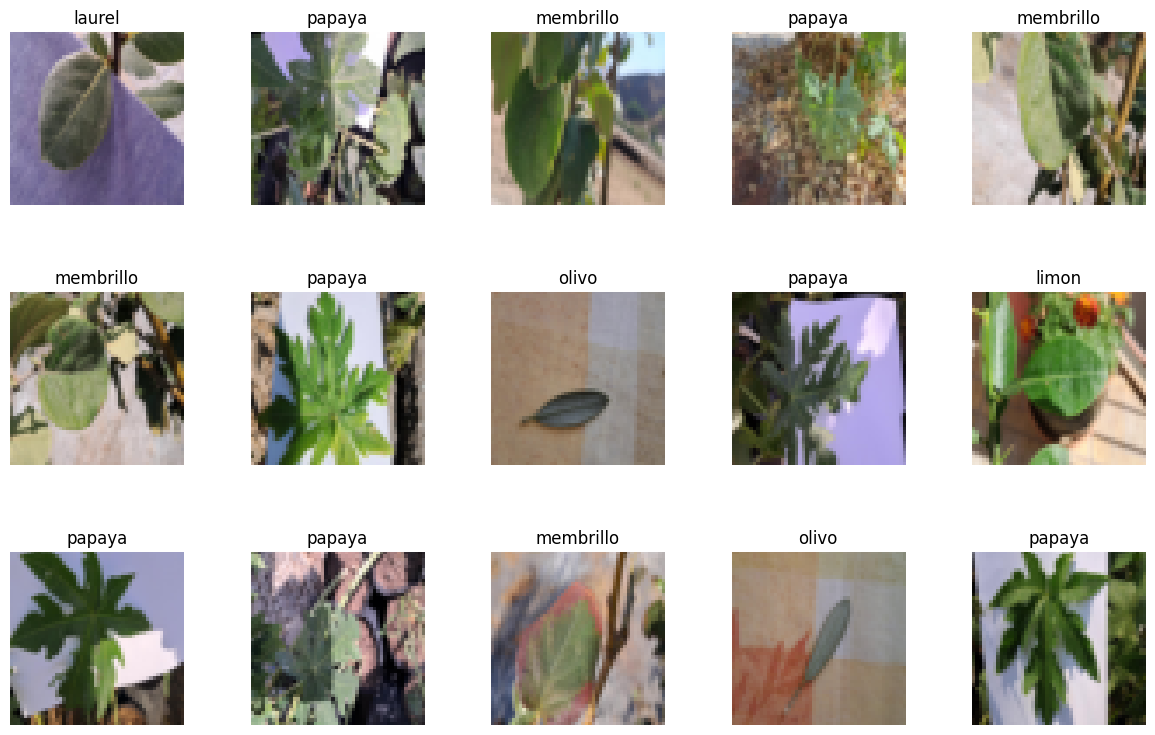

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img.numpy()  # Convertir a numpy array
    img = np.transpose(img, (1, 2, 0))  # Cambiar el formato a (H, W, C)
    plt.imshow(img)
    plt.axis('off')

r, c = 3, 5
plt.figure(figsize=(c * 3, r * 3))

for row in range(r):
    for col in range(c):
        index = c * row + col
        plt.subplot(r, c, index + 1)
        ix = random.randint(0, len(trainset) - 1)
        img, label = trainset[ix]

        # Visualizar imagen
        imshow(img)
        plt.title(classes[label])

plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## 2. GAN simple

In [4]:
import torch
import torchvision

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## MLP para el discriminador y generador

In [5]:
import torch.nn as nn

def block(n_in, n_out):
    return nn.Sequential(
        nn.Linear(n_in, n_out),
        nn.ReLU(inplace=True)
    )

class MLP(nn.Module):
    def __init__(self, input_size, output_size):                    # JUGANDO CON EL TAMAÑO DE ENTRADA Y SALIDA, VAMOS A DEFINIR TANTO AL GENERADOR COMO DISCRIMINADOR
                                                                    # SEGÚN ÉSTOS VALORES SERÁ EL GENERADOR O DISCRIMINADOR
        super().__init__()
        self.input_size = input_size
        self.fc1 = block(input_size, 150)  # Capa 1                 # RED NEURONAL CON 3 CAPAS: fc1, fc2, fc3. CADA CAPA SEGUIDA DE UNA ACTIVACIÓN ReLU()
        self.fc2 = block(150, 100)         # Capa 2
        self.fc3 = nn.Linear(100, output_size)  # Capa 3

    def forward(self, x):                                           # FUNCIÓN forward(), APLICAMOS DE FORMA SECUENCIAL A TODAS LAS CAPAS Y DEVOLVEMOS LA SALIDA
        # Aplana las imágenes en un vector (batch_size, 50x50=2500)
        x = x.view(x.size(0), -1)  # x.size(0) es el batch_size, el -1 aplana las otras dimensiones
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x

In [ ]:
MLP

__main__.MLP

## Primero: Instanciar el generador

In [ ]:
# DEFINICIÓN de n_in y n_out
n_in = 30                            # Este es un hiperparámetro que podemos ajustar. Representa la codificación de características latentes
                                      # Aquí, 30 dimensiones pueden representar características como textura de las hojas, color, forma, etc.
n_out = 50 * 50                      # Queremos que la salida sea una imagen de 50x50 píxeles, coincidiendo con las dimensiones del dataset de plantas

# Crear el generador con la red MLP
generator = MLP(n_in, n_out)          # Instanciamos la clase MLP con los parámetros definidos: 30 valores latentes de entrada y 2500 píxeles de salida
                                      # Esto va a generar una imagen de 50x50 a partir de un vector de 30 valores latentes


In [ ]:
output = generator(torch.randn(64, 30))     # UNA VEZ INSTANCIADO, LE PASAMOS VALORES DE MUESTRA, QUIERO GENERAR UN BATCH DE 64 IMÁGENES CON LOS 30 VALORES
output.shape                                # RESULTADO: A LAS SALIDA TENEMOS 64 IMÁGENES, CADA IMAGEN CON 2500 VALORES.

torch.Size([64, 2500])

EL GENERADOR INICIALIZADO NO SABE GENERAR IMÁGENES POR LO QUE NOS DA EL RUIDO DIRECTAMENTE.\
SI ESTUVIESE YA ENTRENADO VERÍAMOS IMÁGENES REALISTAS QUE SE PARECERÍAN A LAS DEL DATASET.

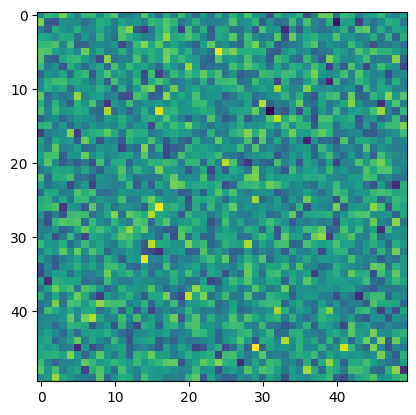

In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
plt.imshow(output[0].reshape(50,50).detach().numpy())
plt.show()

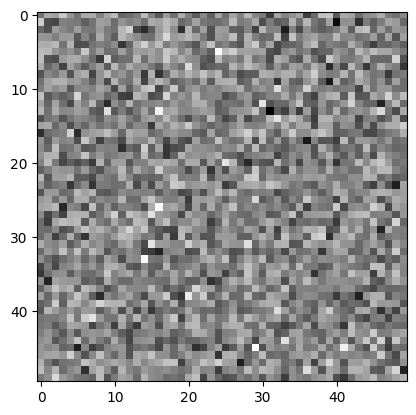

In [ ]:
# Ajustamos la forma de la imagen de salida para que coincida con 28x37
plt.imshow(output[0].reshape(50, 50).detach().numpy(), cmap='gray')
plt.show()

## Segundo: Instanciar el discriminador
El discriminador recibe a la entrada una imagen (28 x 37 valores) y a la salida nos da una clasificación binaria: real o falso.

In [ ]:
# Ajustar el discriminador para imágenes de 50x50 píxeles

discriminator = MLP(50 * 50, 1)       # Recibe imágenes de 50x50 (2500 píxeles) y devuelve 1 (real) o 0 (falsa)


# Generar un tensor aleatorio de tamaño (64, 50x50) para simular un batch de 64 imágenes

output = discriminator(torch.randn(64, 50 * 50))    # Le pasamos un batch de 64 imágenes aleatorias de 50x50 píxeles

# VERIFICAR LA FORMA DE LA SALIDA
output.shape                                        # SALIDA DEBE TENER LA FORMA (64, 1), un valor por cada imagen del batch


torch.Size([64, 1])

AL FINAL DEL ENTRENAMIENTO: El discriminador ya no nos sirve.\
Nos quedaremos con el generador que es la red neuronal que nos genera imágenes realistas.

# Función de entrenamiento

In [6]:
import torch
import torch.nn as nn
import numpy as np
from fastprogress import master_bar, progress_bar

def fit(g, d, dataloader, epochs=30, crit=None):            # fit() RECIBE AL GENERADOR g, RECIBE AL DISCRIMINADOR d, TAMBIÉN LE PODEMOS PASAR UNA FUNCIÓN DE PÉRDIDA,
                                                            # SI NO UTILIZA EL binary cross entropy
  g.to(device)              # ENVIAR generador AL GPU
  d.to(device)              # ENVIAR discriminador AL GPU

  g_optimizer = torch.optim.Adam(g.parameters(), lr=3e-4)   # DEFINIR OPTIMIZADOR PARA LAS DOS REDES
  d_optimizer = torch.optim.Adam(d.parameters(), lr=3e-4)

  crit = nn.BCEWithLogitsLoss() if crit == None else crit

  # Listas para almacenar las pérdidas del generador y discriminador
  g_loss, d_loss = [], []

  mb = master_bar(range(1, epochs+1))
  hist = {'g_loss': [], 'd_loss': []}

  # BUCLE DE ENTRENAMIENTO A TRAVÉS DE LAS EPOCHS
  for epoch in mb:
    for X, y in progress_bar(dataloader, parent=mb):
      X, y = X.to(device), y.to(device)

      # PRIMERO: ENTRENAMOS EL DISCRIMINADOR
      g.eval()                  # GENERADOR EN MODO eval() PARA NO ENTRENARLO
      d.train()                 # DISCRIMINADOR EN MODO train() PARA ENTRENARLO

      # Generamos un batch de imágenes falsas usando el generador
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)

      # CREAR EL input DEL DISCRIMINADOR
      # CONCATENAR LAS IMÁGENES FALSAS Y LAS REALES (PLANTAS) COMO ENTRADA DEL DISCRIMINADOR
      d_input = torch.cat([genenerated_images, X.view(X.size(0), -1)])          # LE PASAMOS AL DISCRIMINADOR LAS IMÁGENES FALSA Y LAS REALES

      # CREAR LAS ETIQUETAS (ground truth) PARA EL DISCRIMINADOR
      d_gt = torch.cat([torch.zeros(X.size(0)), torch.ones(X.size(0))]).view(-1,1).to(device)   # NECESITAMOS TAMBIÉN ETIQUETAS:
                                                                                                # ETIQUETA zeros IMÁGENES FALSAS, ones IMÁGENES VERDADERAS
                                                                                                # HASTA AQUÍ YA TENEMOS inputs Y outputs PARA EL DISCRIMINADOR
      #   optimización del discriminador
      d_optimizer.zero_grad()
      d_output = d(d_input)
      d_l = crit(d_output, d_gt)
      d_l.backward()
      d_optimizer.step()
      d_loss.append(d_l.item())

      # SEGUNDO: ENTRENAMOS AL GENERADOR
      g.train()                                         # MODO train() PARA EL GENERADOR
      d.eval()

      #  Generar un nuevo batch de imágenes falsas
      noise = torch.randn((X.size(0), g.input_size)).to(device)
      genenerated_images = g(noise)                     # AHORA ÉSTE VECTOR DE RUIDO SE LO DAMOS AL GENERADOR

      # EL DISCRIMINADOR DA SU OPINIÓN SOBRE ESTAS IMÁGENES FALSAS
      d_output = d(genenerated_images)                  # SALIDAS DEL DISCRIMINADOR
                                                        # QUEREMOS QUE EL DISCRIMINADOR DIGA QUE TODAS LAS IMÁGENES SON REALES, QUE TODOS SON 1


      #  grand truth para el generator
      g_gt = torch.ones(X.size(0)).view(-1,1).to(device)  # g_gt SON LAS ETIQUETAS

      # Optimización del generador
      g_optimizer.zero_grad()                             # AHORA UTILZAMOS ESOS VALORES PARA OPTIMIZAR EL GENERADOR
      g_l = crit(d_output, g_gt)
      g_l.backward()
      g_optimizer.step()
      g_loss.append(g_l.item())

      # LOGS Y PROGRESO
      mb.child.comment = f'g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}'

    # ESCRIBIR LOS RESULTADOS DE CADA EPOCH
    mb.write(f'Epoch {epoch}/{epochs} g_loss {np.mean(g_loss):.5f} d_loss {np.mean(d_loss):.5f}')

    # GUARDAR LOS RESULTADOS EN EL HISTORIAL
    hist['g_loss'].append(np.mean(g_loss))
    hist['d_loss'].append(np.mean(d_loss))
  return hist                                             # DEVOLVER EL HISTORIAL DE PÉRDIDAS

In [ ]:
# Tamaño de las imágenes aplanadas: 50x50 píxeles y 3 canales (RGB)
input_size = 30  # Tamaño del vector de ruido para el generador
output_size = 3 * 50 * 50  # Tamaño de la imagen aplanada (3 canales RGB y 50x50 píxeles)

# Instanciar el generador y el discriminador
generator = MLP(input_size=input_size, output_size=output_size)
discriminator = MLP(input_size=output_size, output_size=1)

# Llamar a la función fit() con el generador y discriminador
hist = fit(generator, discriminator, trainloader, epochs=30)

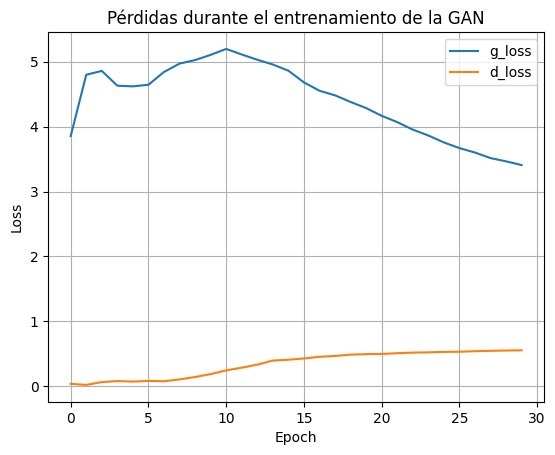

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertimos el historial de pérdidas a un DataFrame de pandas
df = pd.DataFrame(hist)

# Graficamos las pérdidas del generador y el discriminador
df.plot(grid=True, title="Pérdidas durante el entrenamiento de la GAN", xlabel="Epoch", ylabel="Loss")

# Mostrar la gráfica
plt.show()


LA FUNCIÓN DE PÉRDIDA DEL GENERADOR VA BAJANDO LO QUE NOS INDICA QUE EL GENERADOR ESTÁ GENERANDO CADA VEZ MEJORES IMÁGENES Y ES LO QUE QUEREMOS.

## Generacion de imagenes utilizando el generador

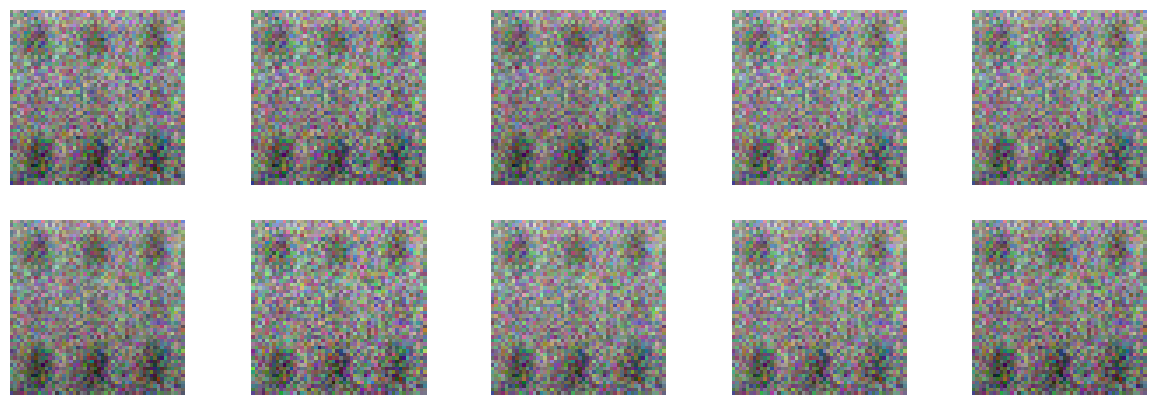

In [ ]:
generator.eval()  # PONER EN MODO eval()
with torch.no_grad():  # SIN CALCULAR GRADIENTES
    # Generar ruido para un batch de 10 vectores, con tamaño igual a la entrada del generador
    noise = torch.randn((10, generator.input_size)).to(device)
    # Generar imágenes a partir del ruido
    generated_images = generator(noise)

    # Configurar la figura para mostrar las imágenes generadas (2 filas, 5 columnas)
    fig, axs = plt.subplots(2, 5, figsize=(15, 5))
    i = 0
    for ax in axs:
        for _ax in ax:
            # Cada imagen generada tiene tamaño 50x50 y 3 canales de color (RGB)
            img = generated_images[i].view(50, 50, 3).cpu().numpy()  # Convertir a numpy para visualizar
            img = (img - img.min()) / (img.max() - img.min())  # Normalizar los valores de la imagen entre 0 y 1
            _ax.imshow(img)  # Mostrar la imagen en el subplot
            _ax.axis('off')  # Ocultar los ejes
            i += 1

    plt.show()


## 3. DCGANs Entrenamiento con redes convolucionales
Este tipo de red neuronal es especialmente diseñada para trabajar con imágenes. Con éste modelo se podrán mejorar las imágenes generadas por el generador.

## Implementación del generador

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_size = 100   # El generador toma un Vector de ruido de tamaño 100.
                                # CUANTAS NEURONAS LE PONEMOS A LA ENTRADA, VERSIÓN CODIFICADA DE LA IMAGEN QUE PERMITE CONTROLAR LA APARIENCIA

        # Secuencia inicial para convertir el ruido en una representación inicial
        self.inp = nn.Sequential(
            nn.Linear(self.input_size, 13*13*128),  # Ajustamos el tamaño a 13x13. Un tamaño intermedio, usando capas con stride=2, se puede duplicar el tamaño en cada paso
            nn.BatchNorm1d(13*13*128),              # Normaliza los valores de salida de capa lineal para que estén en una distribución estándar (mejor estabilidad entrenamiento).
            nn.ReLU(True),                          # ReLU solo deja pasar valores positivos
        )

        # Capas convolucionales transpuestas para generar una imagen de 50x50. self.main -> CUERPO PRINCIPAL DE LA RED

        self.main = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1, bias=False),  # Salida: 26x26
            nn.BatchNorm2d(64),
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1, bias=False),  # Salida: 50x50
            nn.BatchNorm2d(32),
            nn.ReLU(True),

            nn.Conv2d(32, 3, 3, stride=1, padding=1, bias=False),  # Mantiene la salida en 50x50
            nn.Tanh(),  # Valores entre -1 y 1
        )

    def forward(self, x):
        x = self.inp(x)
        x = x.view(-1, 128, 13, 13)  # Redimensionar a 13x13
        x = self.main(x)  # Pasar por las capas convolucionales transpuestas
        return x  # Imagen de salida de tamaño [batch_size, 3, 50, 50]


In [8]:
# Crear una instancia del generador
generator = Generator().to(device)

# Generamos un batch de 64 vectores de ruido (cada uno de 100 dimensiones)
noise = torch.randn(64, 100).to(device)  # Asegúrate de pasar el ruido al dispositivo adecuado

# Pasamos el ruido por el generador para generar imágenes
output = generator(noise)

# Verificamos la forma de la salida
print(output.shape)  # La salida debe ser (64, 3, 50, 50), es decir, 64 imágenes RGB de 50x50 píxeles


torch.Size([64, 3, 52, 52])


Al final del generador usamos una activación `tanh`, que dará valores entre -1 y 1. Por este motivo tenemos que re-normalizar nuestras imágenes en el dataset.

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, trainset):
    self.imgs = torch.tensor([np.array(i[0]).flatten() / 255. for i in trainset], dtype=torch.float, device=device)

    self.imgs = self.imgs * 2. - 1.   # SE AÑADE ÉSTA LÍNEA. UNA VEZ QUE LAS IMÁGENES ESTÉN NORMALIZADAS ENTRE -1 Y 1, LE MULTIPLICAMOS POR 2 Y LE RESTAMOS 1
                                      # Y LAS PODREMOS COMPARAR DIRECTAMENTE CON LAS GENERADAS POR EL GENERADOR

    self.labels = torch.tensor([i[1] for i in trainset], dtype=torch.long, device=device)

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, ix):
    return self.imgs[ix], self.labels[ix]

train = Dataset(trainset)
len(train)

In [ ]:
img, label = train[0]
img.shape, img.dtype, img.max(), img.min()

In [ ]:
dataloader = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)

imgs, labels = next(iter(dataloader))
imgs.shape, labels.shape

En cuanto al discriminador, utilizaremos una `CNN` típica como las que conocemos cuando hacemos clasificación de imagen.

## Implementación del discriminador

In [ ]:
"""
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),  # Entrada de 3 canales (RGB)
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),  # Salida 128 canales
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),  # Añadimos otra capa para ajustar dimensiones
            nn.BatchNorm2d(256),
            nn.ReLU(True)
        )
        # Ajustamos la capa lineal para las dimensiones correctas después de convoluciones
        self.out = nn.Sequential(
            nn.Linear(256*6*6, 1),  # 256 canales, tamaño de mapa de características 6x6
            nn.Sigmoid()
        )

    def forward(self, x):
        # x debe tener la forma [batch_size, 3, 50, 50]
        x = self.main(x)
        x = x.view(x.size(0), -1)  # Aplanar antes de pasar a la capa lineal
        x = self.out(x)
        return x
"""

In [12]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1, bias=False),  # Convolución inicial para reducir la dimensión
            nn.LeakyReLU(0.2, inplace=True),  # LeakyReLU con un pequeño valor negativo para evitar el problema de desvanecimiento del gradiente
            nn.Conv2d(64, 128, 4, stride=2, padding=1, bias=False),  # Aumentar el número de filtros
            nn.BatchNorm2d(128),  # Normalización por lotes para estabilizar el entrenamiento
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1, bias=False),  # Aumentar aún más el número de filtros
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1, bias=False),  # Última capa convolucional antes del aplanamiento
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Flatten(),  # Aplanar la salida para pasarla a una capa lineal
            nn.Linear(512*3*3, 1),  # Capa lineal que produce un solo valor de salida (probabilidad de que la imagen sea real)
            nn.Sigmoid()  # Función de activación sigmoide para obtener una probabilidad entre 0 y 1
        )

    def forward(self, x):
        return self.main(x)

In [13]:
# Crear una instancia del discriminador
discriminator = Discriminator()

# Crear un batch de 64 imágenes de tamaño 50x50 con 3 canales (RGB)
input_images = torch.randn(64, 3, 50, 50)  # [batch_size, 3, 50, 50]

# Pasar las imágenes por el discriminador
output = discriminator(input_images)

# Mostrar la forma de la salida
print(output.shape)

torch.Size([64, 1])


Ahora podemos utilizar exactamente el mismo bucle de entrenamiento anterior para obtener un nuevo generador.

In [15]:
hist = fit(generator, discriminator, trainloader, crit=torch.nn.BCELoss())

RuntimeError: Tensors must have same number of dimensions: got 4 and 2

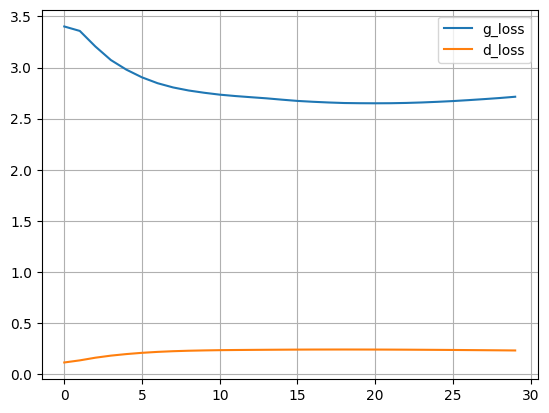

In [ ]:
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

## Generamos imágenes

In [ ]:
generator.eval()
with torch.no_grad():
  noise = torch.randn((10, generator.input_size)).to(device)
  generated_images = generator(noise)
  fig, axs = plt.subplots(2,5,figsize=(15,5))
  i = 0
  for ax in axs:
    for _ax in ax:
      img = generated_images[i].view(28,28).cpu()
      _ax.imshow(img)
      i+=1
  plt.show()

NameError: name 'generator' is not defined

En este caso las imágenes generadas son un poco mejores que las que obteníamos con la *GAN* simple, aunque todavía hay márgen de mejora.